# **POINTNET WITH K-FOLD**

In [1]:
# necessary imports
import os
import numpy
import pandas
import random
import trimesh
import logging
import itertools
import tensorflow
from matplotlib import pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models, layers, regularizers, optimizers
from sklearn.model_selection import train_test_split, StratifiedKFold
from tensorflow.keras.layers import Dense, Activation, Flatten, Dropout, BatchNormalization
from tensorflow.keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Conv2D, MaxPooling2D

# increase matplotlib plots font size
plt.rcParams.update({'font.size': 15})

# The below is necessary for reproducible results of certain Python hash-based operations.
os.environ["PYTHONHASHSEED"] = "0"

# The below is necessary for starting Numpy generated random numbers in a well-defined initial state.
numpy.random.seed(31)

# The below is necessary for starting core Python generated random numbers in a well-defined state.
random.seed(14)

# The below tf.random.set_seed will make random number generation in TensorFlow have a well-defined initial state.
tensorflow.random.set_seed(1234)

# dataset root path
DATASET_ROOT = '/run/media/rr/M2/DevOps/jupyter-lab/CIDL/dataset/'

# final preprocessed dataset directory path
DATASET_PATH = os.path.join(DATASET_ROOT, 'Preprocessed')

# directory where to save the best model for each fold
images_models_save_dir = 'saved_models/images'
pointclouds_models_save_dir = 'saved_models/pointclouds'

# needed to create pointclouds dataset
class_labels_dict = {'table':0, 'chair':1, 'lamp':2, 'dresser':3, 'sofa':4}

# utility function
def get_model_name(model_name, fold_counter):
    return model_name + '-fold-' + str(fold_counter) + '.h5'

# utility function to augment pointclouds data
def augment(points, label):
    # jitter points
    points += tensorflow.random.uniform(points.shape, -0.005, 0.005, dtype=tensorflow.float64)
    # shuffle points
    points = tensorflow.random.shuffle(points)
    return points, label

# plot loss and acuracy for each epoch
def plot_train_loss_accuracy(save_path, train_loss, train_accuracy, val_loss, val_accuracy):
    #print('Training Set Loss: ', train_loss)
    #print('Validation Set Loss: ', val_loss)
    plt.figure(figsize=(10, 10))
    plt.plot(train_loss,'o-g', label="Training Set")
    plt.plot(val_loss,'o-r', label="Validation Set")
    plt.title('Training and Validation Sets Loss')
    plt.legend(loc="upper right")
    plt.savefig(save_path + '-train-val-loss.jpg', dpi=200)
    plt.show()
    #print('Training Set Accuracy: ', train_accuracy)
    #print('Validation Set Accuracy: ', val_accuracy)
    plt.figure(figsize=(10, 10))
    plt.plot(train_accuracy,'o-g', label="Training Set")
    plt.plot(val_accuracy,'o-r', label="Validation Set")
    plt.title('Training and Validation Sets Accuracy')
    plt.legend(loc="lower right")
    plt.savefig(save_path + '-train-val-accuracy.jpg', dpi=200)
    plt.show()

def plot_confusion_matrix(cm, classes, save_path, normalize=True, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.figure(figsize=(10,10))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    tick_marks = numpy.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, numpy.newaxis]
        cm = numpy.around(cm, decimals=2)
        cm[numpy.isnan(cm)] = 0.0
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')
    
    thresh = cm.max() / 2.

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(save_path + '-confusion-matrix.jpg', bbox_inches='tight', dpi=200)
    plt.show()

In [2]:
# only log critical messages
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

In [3]:
# load images csv file
images_data = pandas.read_csv(os.path.join(DATASET_PATH, 'images.csv'))

# extract images path and class labels
images_X = images_data[['filename']]
images_Y = images_data[['class_label']]

# load pointclouds csv file
pointclouds_data = pandas.read_csv(os.path.join(DATASET_PATH, 'pointclouds.csv'))

# extract images path and class labels
pointclouds_X = pointclouds_data[['filename']]
pointclouds_Y = pointclouds_data[['class_label']]

## **Stratified K-Fold Cross Validation for pointclouds**

In [4]:
def pointclouds_kfold_validation(model_name, n_splits, test_size, shuffle, layers, learning_rate, decay, target_size, epochs, batch_size, resample_data=0):
    global pointclouds_data
    global pointclouds_X
    global pointclouds_Y
    if resample_data > 0:
        pointclouds_data = pointclouds_data.groupby('class_label', group_keys=False).apply(lambda x: x.sample(min(len(x), resample_data), random_state=42))
        pointclouds_X = pointclouds_data[['filename']]
        pointclouds_Y = pointclouds_data[['class_label']]

    # fold counter
    fold_counter = 1
    
    # arrays to store test set loss and accuracy scores for each fold
    TEST_LOSS = []
    TEST_ACCURACY = []
    
    # split train and test dataset
    pointclouds_train, pointclouds_test = train_test_split(pointclouds_data, test_size=test_size, stratify=pointclouds_Y, random_state=42)
    pointclouds_train_X = pointclouds_train[['filename']]
    pointclouds_train_Y = pointclouds_train[['class_label']]

    # define stratified k fold cross validation parameters
    stratified_kfold = StratifiedKFold(n_splits=n_splits, random_state=7, shuffle=shuffle)

    # test data arrays
    test_pointclouds = []
    test_labels = []
    test_string_labels = {}

    # test split ready
    for index, test_data_row in pointclouds_test.iterrows():
        test_pointclouds.append(trimesh.load(test_data_row['filename'], force='mesh').sample(target_size))
        test_labels.append(class_labels_dict[test_data_row['class_label']])
        test_string_labels[index] = test_data_row['class_label']
    
    # convert to numpy array
    test_pointclouds = numpy.array(test_pointclouds)
    test_labels = numpy.array(test_labels)

    # create test tf.data.Dataset
    test_dataset = tensorflow.data.Dataset.from_tensor_slices((test_pointclouds, test_labels))
    test_dataset = test_dataset.shuffle(len(test_pointclouds)).batch(batch_size)
    print("Found " + str(len(pointclouds_test)) + " validated pointcloud filenames belonging to " + str(len(pointclouds_test['class_label'].unique())) + " classes.")


    # generate train and validation folds
    for train_index, validation_index in stratified_kfold.split(pointclouds_train_X, pointclouds_train_Y):
        print("\n-------- STARTING FOLD: " + str(fold_counter) + " --------")

        # best model save path
        if not os.path.isdir(os.path.join(pointclouds_models_save_dir, model_name)):
            os.mkdir(os.path.join(pointclouds_models_save_dir, model_name))
        pointclouds_model_save_path = os.path.join(pointclouds_models_save_dir, model_name, get_model_name(model_name, fold_counter))

        # train and validation data arrays
        train_pointclouds = []
        train_labels = []
        train_string_labels = {}
        validation_pointclouds = []
        validation_labels = []
        validation_string_labels = {}

        # training and test folds indices
        training_data = pointclouds_train.iloc[train_index]
        validation_data = pointclouds_train.iloc[validation_index]

        for index, training_data_row in training_data.iterrows():
            train_pointclouds.append(trimesh.load(training_data_row['filename'], force='mesh').sample(target_size))
            train_labels.append(class_labels_dict[training_data_row['class_label']])
            train_string_labels[index] = training_data_row['class_label']

        # convert to numpy array
        train_pointclouds = numpy.array(train_pointclouds)
        train_labels = numpy.array(train_labels)

        # create train tf.data.Dataset
        train_dataset = tensorflow.data.Dataset.from_tensor_slices((train_pointclouds, train_labels))
        train_dataset = train_dataset.shuffle(len(train_pointclouds)).map(augment).batch(batch_size)
        print("Found " + str(len(training_data)) + " validated pointcloud filenames belonging to " + str(len(training_data['class_label'].unique())) + " classes.")

        for index, validation_data_row in validation_data.iterrows():
            validation_pointclouds.append(trimesh.load(validation_data_row['filename'], force='mesh').sample(target_size))
            validation_labels.append(class_labels_dict[validation_data_row['class_label']])
            validation_string_labels[index] = validation_data_row['class_label']

        # convert to numpy array
        validation_pointclouds = numpy.array(validation_pointclouds)
        validation_labels = numpy.array(validation_labels)

        # create train tf.data.Dataset
        validation_dataset = tensorflow.data.Dataset.from_tensor_slices((validation_pointclouds, validation_labels))
        validation_dataset = validation_dataset.shuffle(len(validation_pointclouds)).map(augment).batch(batch_size)
        print("Found " + str(len(validation_data)) + " validated pointcloud filenames belonging to " + str(len(validation_data['class_label'].unique())) + " classes.")

        # create best model checkpoint
        best_model_checkpoint = tensorflow.keras.callbacks.ModelCheckpoint(pointclouds_model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
        callbacks_list = [best_model_checkpoint]

        # define model to be trained and tested
        model = models.Sequential(name=model_name + "-" + str(fold_counter))
        for layer in layers:
            model.add(layer)
        model.summary()

        model.compile(
            loss="sparse_categorical_crossentropy",
            optimizer=tensorflow.keras.optimizers.Adam(learning_rate=learning_rate, decay=decay),
            metrics=["sparse_categorical_accuracy"],
        )

        history = model.fit(train_dataset, epochs=epochs, validation_data=validation_dataset)

        # plot loss and acuracy for each training/validation fold
        plot_train_loss_accuracy(pointclouds_model_save_path, history.history["loss"], history.history["sparse_categorical_accuracy"],
                                 history.history["val_loss"], history.history["val_sparse_categorical_accuracy"])

        # LOAD BEST MODEL to evaluate the performance of the model on the test set
        model.load_weights(pointclouds_model_save_path)

        # evaluate the model on the test set
        test_loss, test_accuracy = model.evaluate(test_dataset, batch_size=batch_size)
        print("Best model Test Loss: " + str(test_loss))
        print("Best model Test Accuracy: " + str(test_accuracy))
        
        # store test set loss and accuracy scores for each fold
        TEST_LOSS.append(test_loss)
        TEST_ACCURACY.append(test_accuracy)

        # Confution Matrix 
        Y_pred = model.predict(test_dataset)
        y_pred = numpy.argmax(Y_pred, axis=1)
        print('Confusion Matrix')
        cm = confusion_matrix(test_labels, y_pred)
        plot_confusion_matrix(cm, class_labels_dict.keys(), pointclouds_model_save_path, title='Confusion Matrix')

        # print Classification Report
        print('Classification Report')
        print(classification_report(test_labels, y_pred, target_names=class_labels_dict.keys()))

        # clean up before next fold
        del model
        tensorflow.keras.backend.clear_session()
        fold_counter += 1

#### **Developer harness test for Stratified K-Fold Cross Validation for pointclouds**

2022-02-06 21:05:11.176351: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 21:05:11.194663: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 21:05:11.194820: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-02-06 21:05:11.195319: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Found 787 validated pointcloud filenames belonging to 5 classes.

-------- STARTING FOLD: 1 --------
Found 2096 validated pointcloud filenames belonging to 5 classes.
Found 1048 validated pointcloud filenames belonging to 5 classes.
Model: "testing-1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 2048, 32)          320       
                                                                 
 batch_normalization (BatchN  (None, 2048, 32)         128       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 2048, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 2048, 64)          6208      
                                                                 
 batch_normalization_1

2022-02-06 21:07:28.871387: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8300
2022-02-06 21:07:29.567063: I tensorflow/stream_executor/cuda/cuda_blas.cc:1774] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


66/66 [==============================] - 4s 27ms/step - loss: 2.0267 - sparse_categorical_accuracy: 0.2858 - val_loss: 2.7558 - val_sparse_categorical_accuracy: 0.2176
Epoch 2/50
66/66 [==============================] - 2s 24ms/step - loss: 1.7841 - sparse_categorical_accuracy: 0.3397 - val_loss: 2.2265 - val_sparse_categorical_accuracy: 0.2128
Epoch 3/50
66/66 [==============================] - 2s 24ms/step - loss: 1.5736 - sparse_categorical_accuracy: 0.3860 - val_loss: 1.6466 - val_sparse_categorical_accuracy: 0.2605
Epoch 4/50
66/66 [==============================] - 2s 24ms/step - loss: 1.5022 - sparse_categorical_accuracy: 0.4094 - val_loss: 2.0158 - val_sparse_categorical_accuracy: 0.2462
Epoch 5/50
66/66 [==============================] - 2s 24ms/step - loss: 1.4623 - sparse_categorical_accuracy: 0.4470 - val_loss: 8.4672 - val_sparse_categorical_accuracy: 0.5573
Epoch 6/50
66/66 [==============================] - 2s 24ms/step - loss: 1.3110 - sparse_categorical_accuracy: 0.464

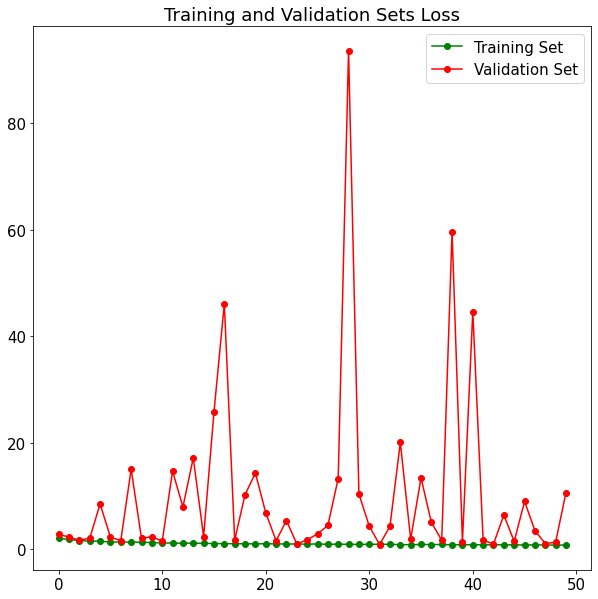

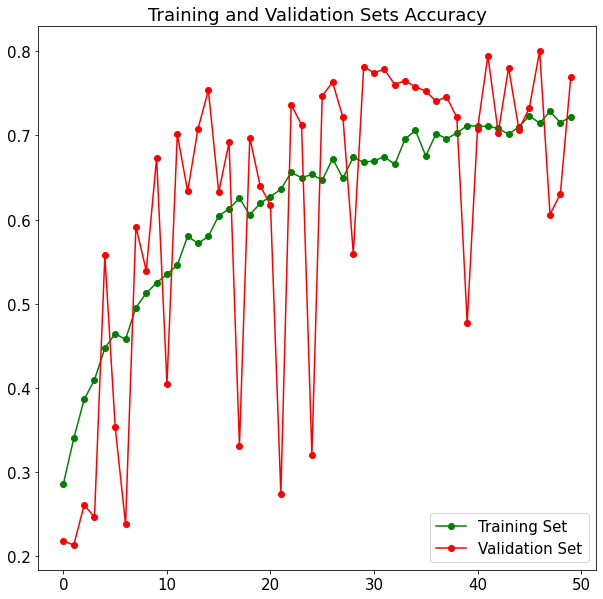

ValueError: Layer count mismatch when loading weights from file. Model expected 10 layers, found 0 saved layers.

In [5]:
# testing
layers = [
    Conv1D(32, 3, padding='same', input_shape=(2048, 3)),
    BatchNormalization(momentum=0.0),
    Activation('relu'),
    Conv1D(64, 3, padding='same', input_shape=(2048, 3)),
    BatchNormalization(momentum=0.0),
    Activation('relu'),
    Conv1D(512, 3, padding='same', input_shape=(2048, 3)),
    BatchNormalization(momentum=0.0),
    Activation('relu'),
    GlobalMaxPooling1D(),
    Dense(512),
    BatchNormalization(momentum=0.0),
    Flatten(),
    Dense(1024),
    Activation('relu'),
    Dense(5, activation='softmax')
]

# train, validate and test
pointclouds_kfold_validation("testing", 3, 0.20, True, layers, 0.001, 1e-6, 2048, 50, 32)